In [2]:
import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import mediapipe as mp

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5)

In [ ]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

if device_product_line == 'L500':
    config.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
else:
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
    
# Start streaming
profile = pipeline.start(config)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

# Create an align object
# rs.align allows us to perform alignment of depth frames to others frames
# The "align_to" is the stream type to which we plan to align depth frames.
align_to = rs.stream.color
align = rs.align(align_to)

try:
    count = 0
    while True:
        count += 1

        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        
        
        # Align the depth frame to color frame
        aligned_frames = align.process(frames)

        # Get aligned frames
        depth_frame = aligned_frames.get_depth_frame() # aligned_depth_frame is a 640x480 depth image
        color_frame = aligned_frames.get_color_frame()      
        
        if not depth_frame or not color_frame:
            continue

        # Convert images to numpy arrays
        depth_image = np.asanyarray(depth_frame.get_data())
#         print("Depth Image Shape = ", depth_image.shape)
        dmap = depth_image.reshape(-1)
        unique, counts = np.unique(dmap[dmap > 100], return_counts=True)
        projection_depth = unique[np.argmax(counts)]*depth_scale
        if count%30==0:
            print("Projection Depth = ", projection_depth)
            with open(f'depth_maps/depth_map_p_{count}.npy', 'wb') as f:
                np.save(f, depth_image)
        color_image = np.asanyarray(color_frame.get_data())
        color_image.flags.writeable = False
        color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)        
        results = hands.process(color_image)
        color_image.flags.writeable = True
        color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
#         print("Color Image Shape = ", color_image.shape)
        
        if results.multi_handedness:
            handedness = [handedness.classification[0].label for handedness in results.multi_handedness]
#         print(handedness)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                min_hand_x = 640
                max_hand_x = 0
                min_hand_y = 480
                max_hand_y = 0
                sum_depth_of_landmarks = 0
                count_landmarks = 0
                for landmark in hand_landmarks.landmark:
                    x = min(int(landmark.x*640), 639)
                    y = min(int(landmark.y*480), 479)
                    min_hand_x = min(x, min_hand_x)
                    max_hand_x = max(x, max_hand_x)
                    min_hand_y = min(y, min_hand_y)
                    max_hand_y = max(y, max_hand_y)
                    if depth_image[y,x] > 0:
                        sum_depth_of_landmarks += depth_image[y,x]
                        count_landmarks += 1
                if count_landmarks > 0 and count%30==0:
                    print("Average Handdepth = ", sum_depth_of_landmarks*depth_scale/count_landmarks)
                color_image = cv2.rectangle(color_image, (min_hand_x, min_hand_y), (max_hand_x, max_hand_y), (255, 0, 0), 2)
                depth_image[min_hand_y:max_hand_y, min_hand_x:max_hand_x] = 0
#                 color_image = cv2.circle(color_image, (hand_x, hand_y), 10, (255, 0, 0), 2)
#                 mp_drawing.draw_landmarks(color_image,
#                                           hand_landmarks,
#                                           mp_hands.HAND_CONNECTIONS,
#                                           mp_drawing_styles.get_default_hand_landmarks_style(),
#                                           mp_drawing_styles.get_default_hand_connections_style())
        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image.shape

        # If depth and color resolutions are different, resize color image to match depth image for display
        if depth_colormap_dim != color_colormap_dim:
            resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            images = np.hstack((resized_color_image, depth_colormap))
        else:
            images = np.hstack((color_image, depth_colormap))

        # Show images
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', images)
        cv2.waitKey(1)

finally:

    # Stop streaming
    pipeline.stop()

In [3]:
dmap = np.load("depth_maps/depth_map_20.npy").reshape(-1)

In [4]:
dmap

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [9]:
dmap = dmap[(dmap>500) & (dmap<1500)]

In [5]:
counts[np.argmax(counts)]

NameError: name 'counts' is not defined

/tmp/ipykernel_314616/1280231840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dmap, hist=False)


Text(0.5, 1.0, 'Depth Calibration')

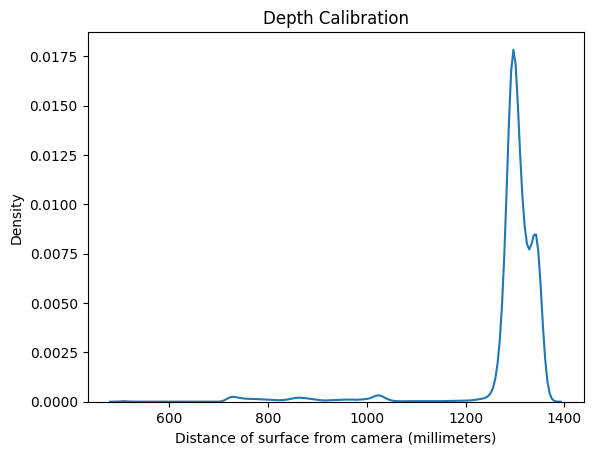

In [12]:
sns.distplot(dmap, hist=False)
plt.xlabel("Distance of surface from camera (millimeters)")
plt.title("Depth Calibration")